# MNIST using Distributed Keras

**Joeri Hermans** (Technical Student, IT-DB-SAS, CERN)             
*Departement of Knowledge Engineering*         
*Maastricht University, The Netherlands*

In [1]:
!(date +%d\ %B\ %G)

26 May 2017


In this notebook we will show you how to process the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset using Distributed Keras. As in the [workflow](https://github.com/JoeriHermans/dist-keras/blob/master/examples/workflow.ipynb) notebook, we will guide you through the complete machine learning pipeline.

## Preparation

To get started, we first load all the required imports. Please make sure you installed `dist-keras`, and `seaborn`. Furthermore, we assume that you have access to an installation which provides Apache Spark.

Before you start this notebook, place the MNIST dataset (which is provided in this repository) on HDFS. Or in the case HDFS is not available, place it on the local filesystem. But make sure the path to the file is identical for all computing nodes.

In [2]:
%matplotlib inline

import numpy as np

import seaborn as sns

from keras.optimizers import *
from keras.models import Sequential
from keras.layers.core import *
from keras.layers.convolutional import *

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession


from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from distkeras.trainers import *
from distkeras.predictors import *
from distkeras.transformers import *
from distkeras.evaluators import *
from distkeras.utils import *

Using TensorFlow backend.


In the following cell, adapt the parameters to fit your personal requirements.

In [3]:
# Modify these variables according to your needs.
application_name = "Distributed Keras MNIST"
using_spark_2 = True
local = True
path_train = "data/mnist_train.csv"
path_test = "data/mnist_test.csv"
if local:
    # Tell master to use local resources.
#     master = "local[*]"
    master = "spark://192.168.10.10:7077"
    num_processes = 1
    num_executors = 3
else:
    # Tell master to use YARN.
    master = "yarn-client"
    num_executors = 20
    num_processes = 1
    

In [5]:

# This variable is derived from the number of cores and executors, and will be used to assign the number of model trainers.
num_workers = num_executors * num_processes

print("Number of desired executors: " + str(num_executors))
print("Number of desired processes / executor: " + str(num_processes))
print("Total number of workers: " + str(num_workers))


Number of desired executors: 3
Number of desired processes / executor: 1
Total number of workers: 3


In [6]:
import os

# Use the DataBricks CSV reader, this has some nice functionality regarding invalid values.
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-csv_2.10:1.4.0 pyspark-shell'

In [7]:
conf = SparkConf()
conf.set("spark.app.name", application_name)
conf.set("spark.master", master)
conf.set("spark.executor.cores", num_processes)
conf.set("spark.executor.instances", num_executors)
conf.set("spark.executor.memory", "1g")
conf.set("spark.locality.wait", "0")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer");

# Check if the user is running Spark 2.0 +
if using_spark_2:
    sc = SparkSession.builder.config(conf=conf) \
            .appName(application_name) \
            .getOrCreate()
else:
    # Create the Spark context.
    sc = SparkContext(conf=conf)
    # Add the missing imports
    from pyspark import SQLContext
    sqlContext = SQLContext(sc)

In [8]:
# Check if we are using Spark 2.0
if using_spark_2:
    reader = sc
else:
    reader = sqlContext
# Read the training dataset.
raw_dataset_train = reader.read.format('com.databricks.spark.csv') \
                          .options(header='true', inferSchema='true') \
                          .load(path_train)
# Read the testing dataset.
raw_dataset_test = reader.read.format('com.databricks.spark.csv') \
                         .options(header='true', inferSchema='true') \
                         .load(path_test)

As shown in the output of the cell above, we see that every pixel is associated with a seperate column. In order to ensure compatibility with Apache Spark, we vectorize the columns, and add the resulting vectors as a seperate column. However, in order to achieve this, we first need a list of the required columns. This is shown in the cell below.

In [9]:
# First, we would like to extract the desired features from the raw dataset.
# We do this by constructing a list with all desired columns.
# This is identical for the test set.
features = raw_dataset_train.columns
features.remove('label')

Once we have a list of columns names, we can pass this to Spark's [VectorAssembler](http://spark.apache.org/docs/latest/ml-features.html#vectorassembler). This VectorAssembler will take a list of features, vectorize them, and place them in a column defined in `outputCol`.

In [10]:
# Next, we use Spark's VectorAssembler to "assemble" (create) a vector of all desired features.
# http://spark.apache.org/docs/latest/ml-features.html#vectorassembler
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
# This transformer will take all columns specified in features, and create an additional column "features" which will contain all the desired features aggregated into a single vector.
dataset_train = vector_assembler.transform(raw_dataset_train)
dataset_test = vector_assembler.transform(raw_dataset_test)

Once we have the inputs for our Neural Network (features column) after applying the VectorAssembler, we should also define the outputs. Since we are dealing with a classification task, the output of our Neural Network should be a one-hot encoded vector with 10 elements. For this, we provide a `OneHotTransformer` which accomplish this exact task.

In [11]:
# Define the number of output classes.
nb_classes = 10
encoder = OneHotTransformer(nb_classes, input_col="label", output_col="label_encoded")
dataset_train = encoder.transform(dataset_train)
dataset_test = encoder.transform(dataset_test)

## MNIST

[MNIST](http://yann.lecun.com/exdb/mnist/) is a dataset of handwritten digits. Every image is a 28 by 28 pixel grayscale image. This means that every pixel has a value between 0 and 255. Some examples of instances within this dataset are shown in the cells below.

In [12]:
def show_instances(column):
    global dataset

    num_instances = 6 # Number of instances you would like to draw.
    x_dimension   = 3 # Number of images to draw on the x-axis.
    y_dimension   = 2 # Number of images to draw on the y-axis.

    # Fetch 3 different instance from the dataset.
    instances = dataset_train.select(column).take(num_instances)
    # Process the instances.
    for i in range(0, num_instances):
        instance = instances[i]
        instance = instance[column].toArray().reshape((28, 28))
        instances[i] = instance

    # Draw the sampled instances.
    fig, axn = plt.subplots(y_dimension, x_dimension, sharex=True, sharey=True)
    num_axn = len(axn.flat)
    for i in range(0, num_axn):
        ax = axn.flat[i]
        h = sns.heatmap(instances[i], ax=ax)
        h.set_yticks([])
        h.set_xticks([])

/usr/lib64/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


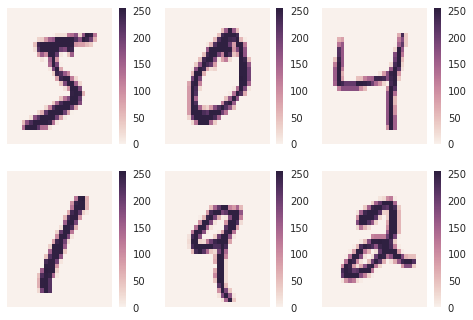

In [13]:
show_instances("features")

## Normalization

In this Section, we will normalize the feature vectors between the 0 and 1 range.

In [14]:
# Clear the dataset in the case you ran this cell before.
dataset_train = dataset_train.select("features", "label", "label_encoded")
dataset_test = dataset_test.select("features", "label", "label_encoded")
# Allocate a MinMaxTransformer using Distributed Keras.
# o_min -> original_minimum
# n_min -> new_minimum
transformer = MinMaxTransformer(n_min=0.0, n_max=1.0, \
                                o_min=0.0, o_max=250.0, \
                                input_col="features", \
                                output_col="features_normalized")
# Transform the dataset.
dataset_train = transformer.transform(dataset_train)
dataset_test = transformer.transform(dataset_test)

/usr/lib64/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


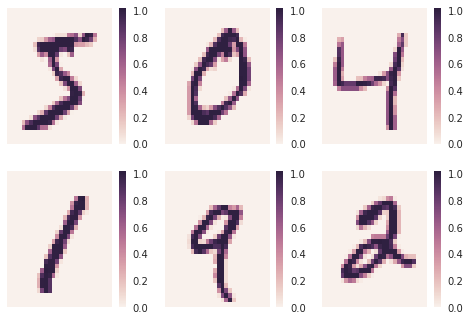

In [15]:
show_instances("features_normalized")

## Convolutions

In order to make the dense vectors compatible with convolution operations in Keras, we add another column which contains the matrix form of these images. We provide a utility class (MatrixTransformer), which helps you with this.

In [16]:
reshape_transformer = ReshapeTransformer("features_normalized", "matrix", (28, 28, 1))
dataset_train = reshape_transformer.transform(dataset_train)
dataset_test = reshape_transformer.transform(dataset_test)

## Model Development

### Multilayer Perceptron

In [17]:
mlp = Sequential()
mlp.add(Dense(1000, input_shape=(784,)))
mlp.add(Activation('relu'))
mlp.add(Dense(250))
mlp.add(Activation('relu'))
mlp.add(Dense(10))
mlp.add(Activation('softmax'))

In [18]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              785000    
_________________________________________________________________
activation_1 (Activation)    (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               250250    
_________________________________________________________________
activation_2 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2510      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 1,037,760
Trainable params: 1,037,760
Non-trainable params: 0
_________________________________________________________________


In [19]:
optimizer_mlp = 'adam'
loss_mlp = 'categorical_crossentropy'

### Convolutional network

In [20]:
# Taken from Keras MNIST example.

# Declare model parameters.
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)
input_shape = (img_rows, img_cols, 1)

# Construct the model.
convnet = Sequential()
convnet.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                          border_mode='valid',
                          input_shape=input_shape))
convnet.add(Activation('relu'))
convnet.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
convnet.add(Activation('relu'))
convnet.add(MaxPooling2D(pool_size=pool_size))

convnet.add(Flatten())
convnet.add(Dense(225))
convnet.add(Activation('relu'))
convnet.add(Dense(nb_classes))
convnet.add(Activation('softmax'))

/usr/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="valid", input_shape=(28, 28, 1...)`
/usr/lib/python3.5/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`


In [21]:
convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_4 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_5 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 225)               1037025   
__________

In [22]:
optimizer_convnet = 'adam'
loss_convnet = 'categorical_crossentropy'

## Evaluation

We define a utility function which will compute the accuracy for us.

In [23]:
def evaluate_accuracy(model, test_set, features="features_normalized_dense"):
    evaluator = AccuracyEvaluator(prediction_col="prediction_index", label_col="label")
    predictor = ModelPredictor(keras_model=model, features_col=features)
    transformer = LabelIndexTransformer(output_dim=nb_classes)
    test_set = test_set.select(features, "label")
    test_set = predictor.predict(test_set)
    test_set = transformer.transform(test_set)
    score = evaluator.evaluate(test_set)
    
    return score

## Training

In [24]:
dataset_train.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)
 |-- label_encoded: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- features_normalized: vector (nullable = true)
 |-- matrix: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: double (containsNull = true)



In [25]:
dataset_train = dataset_train.select("features_normalized", "matrix","label", "label_encoded")
dataset_test = dataset_test.select("features_normalized", "matrix","label", "label_encoded")

In [26]:
dense_transformer = DenseTransformer(input_col="features_normalized", output_col="features_normalized_dense")
dataset_train = dense_transformer.transform(dataset_train)
dataset_test = dense_transformer.transform(dataset_test)
dataset_train.repartition(num_workers)
dataset_test.repartition(num_workers)

DataFrame[features_normalized: vector, matrix: array<array<array<double>>>, label: bigint, label_encoded: array<double>, features_normalized_dense: vector]

In [27]:
# Assing the training and test set.
training_set = dataset_train.repartition(num_workers)
test_set = dataset_test.repartition(num_workers)
# Cache them.
training_set.cache()
test_set.cache()

DataFrame[features_normalized: vector, matrix: array<array<array<double>>>, label: bigint, label_encoded: array<double>, features_normalized_dense: vector]

In [28]:
print(training_set.count())

60000


### DOWNPOUR (Multilayer Perceptron)

In [29]:
trainer = DOWNPOUR(keras_model=mlp, worker_optimizer=optimizer_mlp, loss=loss_mlp, num_workers=num_workers,
                   batch_size=4, communication_window=5, num_epoch=1,
                   features_col="features_normalized_dense", label_col="label_encoded")
trained_model = trainer.train(training_set)

In [30]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set)))

Training time: 295.9362225532532
Accuracy: 0.9628


In [31]:
trainer.parameter_server.num_updates

3001

### ADAG (MultiLayer Perceptron)

In [32]:
trainer = ADAG(keras_model=mlp, worker_optimizer=optimizer_mlp, loss=loss_mlp, num_workers=num_workers,
               batch_size=4, communication_window=15, num_epoch=1,
               features_col="features_normalized_dense", label_col="label_encoded")
trained_model = trainer.train(training_set)

In [33]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set)))

Training time: 209.94440937042236
Accuracy: 0.9667


In [34]:
trainer.parameter_server.num_updates

1000

### EASGD (MultiLayer Perceptron)

In [35]:
trainer = AEASGD(keras_model=mlp, worker_optimizer=optimizer_mlp, loss=loss_mlp, num_workers=num_workers,
                 batch_size=4, communication_window=35, num_epoch=1, features_col="features_normalized_dense",
                 label_col="label_encoded")
trained_model = trainer.train(training_set)

In [36]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set)))

Training time: 181.82912802696228
Accuracy: 0.9566


In [37]:
trainer.parameter_server.num_updates

427

### DOWNPOUR (Convolutional network)

In [38]:
trainer = DOWNPOUR(keras_model=convnet, worker_optimizer=optimizer_convnet, loss=loss_convnet,
                   num_workers=num_workers, batch_size=4, communication_window=5,
                   num_epoch=1, features_col="matrix", label_col="label_encoded")
trainer.set_parallelism_factor(1)
trained_model = trainer.train(training_set)

In [39]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set, "matrix")))

Training time: 390.4994945526123
Accuracy: 0.9848


In [40]:
trainer.parameter_server.num_updates

3001

### ADAG (Convolutional network)

In [41]:
trainer = ADAG(keras_model=convnet, worker_optimizer=optimizer_convnet, loss=loss_convnet,
               num_workers=num_workers, batch_size=15, communication_window=5, num_epoch=1,
               features_col="matrix", label_col="label_encoded")
trainer.set_parallelism_factor(1)
trained_model = trainer.train(training_set)

In [42]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set, "matrix")))

Training time: 175.3152482509613
Accuracy: 0.9825


In [43]:
trainer.parameter_server.num_updates

799

### EASGD (Convolutional network)

In [44]:
trainer = AEASGD(keras_model=convnet, worker_optimizer=optimizer_convnet, loss=loss_convnet, 
                 num_workers=num_workers, batch_size=35, communication_window=32, num_epoch=1,
                 features_col="matrix", label_col="label_encoded")
trained_model = trainer.train(training_set)

In [45]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set, "matrix")))

Training time: 107.23848271369934
Accuracy: 0.9778


In [46]:
trainer.parameter_server.num_updates

52